In [1]:
from kaggle_handler import handler
import pandas as pd
import numpy as np
import string

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")

In [82]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score

In [55]:
from wordcloud import WordCloud
from collections import Counter

In [5]:
Assets = handler('uciml/sms-spam-collection-dataset')

Directory 'Assets' already exists.
Datasets already exist in Assets folder
['spam.csv']
 Change Add_more parameter to download more datasets


In [6]:
Assets

['spam.csv']

In [7]:
df = pd.read_csv('Assets/spam.csv', encoding='iso-8859-1')
df.head(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [8]:
df.shape

(5572, 5)

1. Data Cleaning
2. EDA
3. Text Preprocessing
4. Model building
5. Evaluation
6. Improvement
7. Website
8. Deploy

# Data Cleaning

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [10]:
df.drop(columns=['Unnamed: 2','Unnamed: 3', 'Unnamed: 4'], inplace=True)

In [11]:
df.sample(2)

,v1,v2
4462,ham,He said i look pretty wif long hair wat. But i...
5380,ham,Its sunny in california. The weather's just cool


In [12]:
df.rename(columns={'v1':'target','v2':'text'}, inplace=True)

In [13]:
df.sample(2)

,target,text
3282,ham,Hey tmr maybe can meet you at yck
1636,ham,"No shit, but I wasn't that surprised, so I wen..."


In [14]:
encoder = LabelEncoder()
df['target'] = encoder.fit_transform(df['target'])

In [15]:
df.isna().sum()

target    0
text      0
dtype: int64

In [16]:
df.duplicated().sum()

np.int64(403)

In [17]:
df.drop_duplicates(keep='first', inplace=True)

In [18]:
df.duplicated().sum()

np.int64(0)

In [19]:
df.shape

(5169, 2)

# EDA

In [20]:
df['target'].value_counts()

target
0    4516
1     653
Name: count, dtype: int64

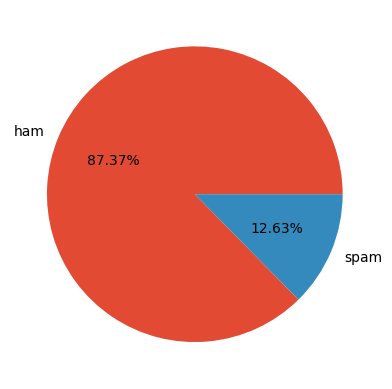

In [21]:
plt.pie(df['target'].value_counts(), labels=['ham','spam'], autopct='%0.2f%%')
plt.show()

# Imbalanced Dataset

In [22]:
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /home/sptrop/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/sptrop/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [23]:
df['num_characters'] = df['text'].apply(len)

In [24]:
df.head(2)

,target,text,num_characters
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29


In [25]:
#  number of words
df['num_words'] = df['text'].apply(lambda x:len(nltk.word_tokenize(x)))

In [26]:
df.head(2)

,target,text,num_characters,num_words
0,0,"Go until jurong point, crazy.. Available only ...",111,24
1,0,Ok lar... Joking wif u oni...,29,8


In [27]:
df['num_sentences'] = df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [28]:
df.head(2)

,target,text,num_characters,num_words,num_sentences
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2


In [29]:
df.describe(include=[np.number])

,target,num_characters,num_words,num_sentences
count,5169.000000,5169.000000,5169.000000,5169.000000
mean,0.126330,78.977945,18.455794,1.965564
std,0.332253,58.236293,13.324758,1.448541
min,0.000000,2.000000,1.000000,1.000000
25%,0.000000,36.000000,9.000000,1.000000
50%,0.000000,60.000000,15.000000,1.000000
75%,0.000000,117.000000,26.000000,2.000000
max,1.000000,910.000000,220.000000,38.000000


In [30]:
#  Ham
df[df['target'] == 0].describe(include=[np.number])

,target,num_characters,num_words,num_sentences
count,4516.0,4516.000000,4516.000000,4516.000000
mean,0.0,70.459256,17.123782,1.820195
std,0.0,56.358207,13.493970,1.383657
min,0.0,2.000000,1.000000,1.000000
25%,0.0,34.000000,8.000000,1.000000
50%,0.0,52.000000,13.000000,1.000000
75%,0.0,90.000000,22.000000,2.000000
max,0.0,910.000000,220.000000,38.000000


In [31]:
# spam
df[df['target'] == 1].describe(include=[np.number])

,target,num_characters,num_words,num_sentences
count,653.0,653.000000,653.000000,653.000000
mean,1.0,137.891271,27.667688,2.970904
std,0.0,30.137753,7.008418,1.488425
min,1.0,13.000000,2.000000,1.000000
25%,1.0,132.000000,25.000000,2.000000
50%,1.0,149.000000,29.000000,3.000000
75%,1.0,157.000000,32.000000,4.000000
max,1.0,224.000000,46.000000,9.000000


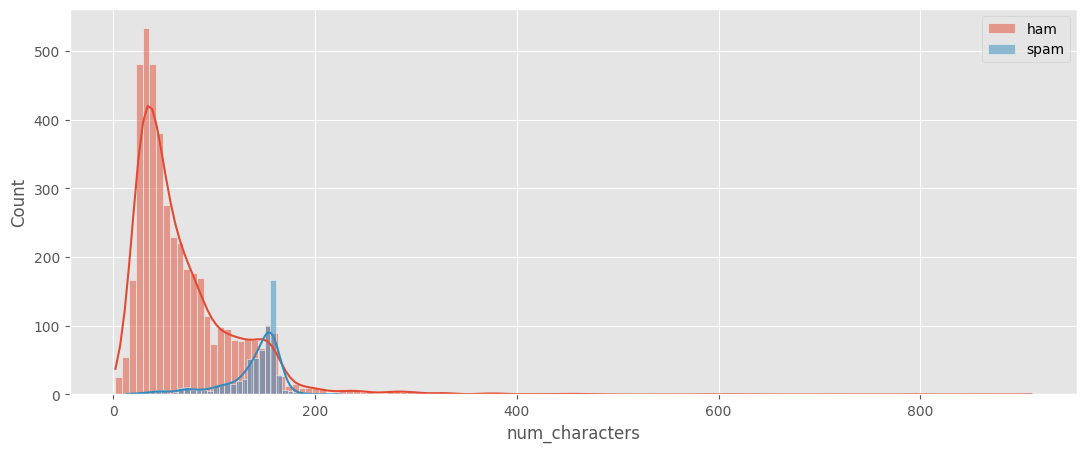

In [32]:
plt.figure(figsize=(13,5))
sns.histplot(df[df['target'] == 0]['num_characters'], kde=True, label='ham')
sns.histplot(df[df['target'] == 1]['num_characters'], kde=True, label='spam')
plt.legend()
plt.show()

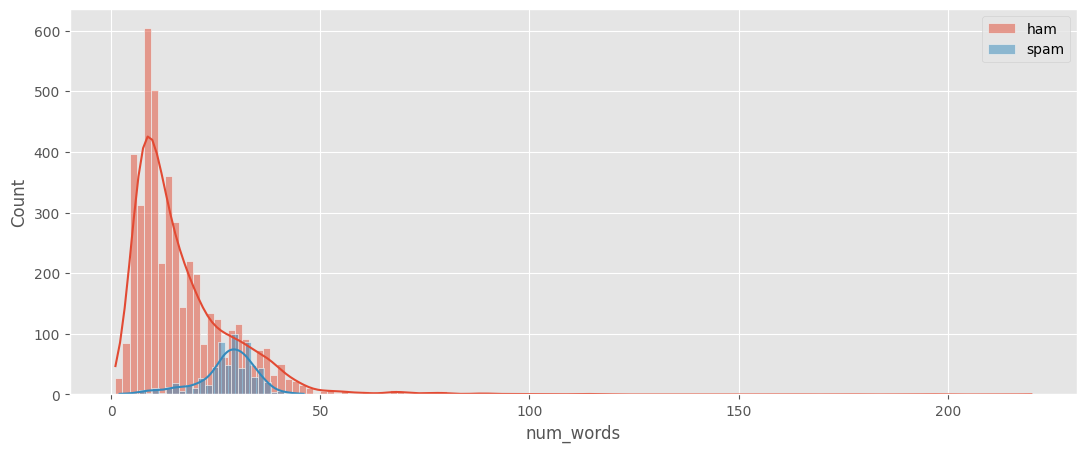

In [33]:
plt.figure(figsize=(13,5))
sns.histplot(df[df['target'] == 0]['num_words'], kde=True, label='ham')
sns.histplot(df[df['target'] == 1]['num_words'], kde=True, label='spam')
plt.legend()
plt.show()

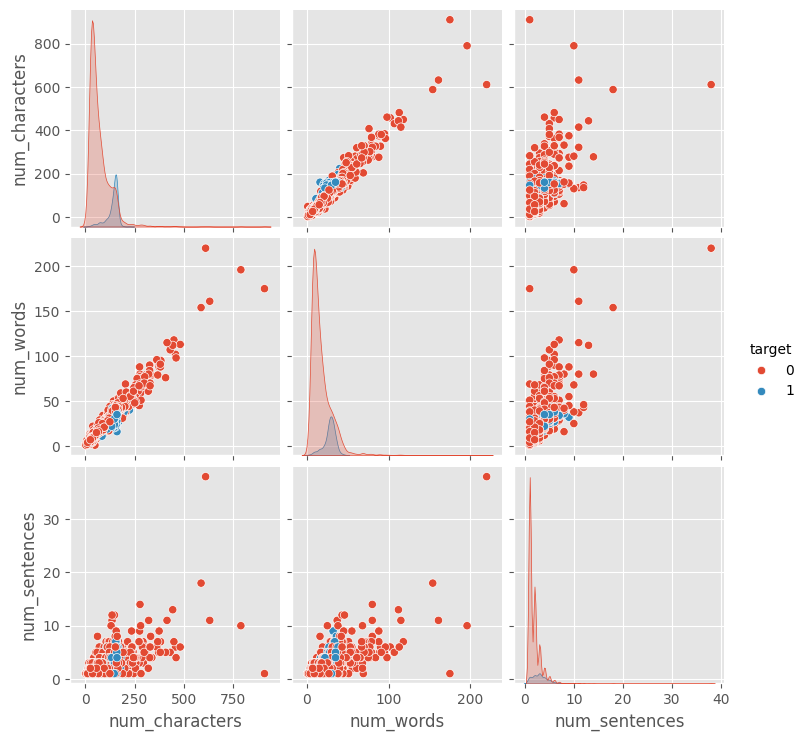

In [34]:
sns.pairplot(df, hue='target')
plt.show()

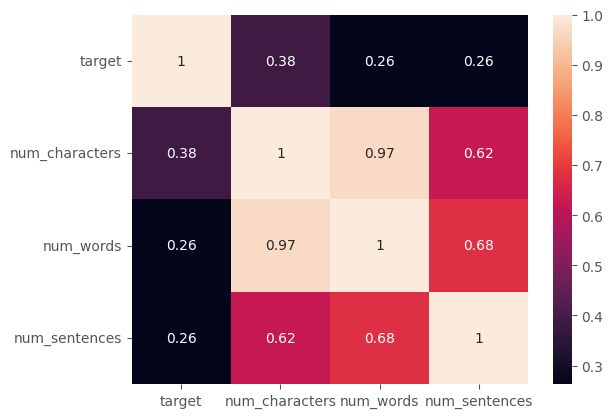

In [35]:
sns.heatmap(df[['target', 'num_characters', 'num_words', 'num_sentences']].corr(), annot=True)
plt.show()

    Num characters, words and sentences are very heighly correlated with each other
        There for, we only take of feature
        That is num_characters because is higest correlation with target

# Data Preprocessing / Text Preprocessing
- Lower Case
- Tokenization
- Removing special characters
- Removing stop words and punctuation
- Stemming

In [36]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/sptrop/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [37]:
ps = PorterStemmer()
def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)

    y = []
    for i in text:
        if i.isalnum():
            y.append(i)

    text = y.copy()
    y.clear()

    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)

    text = y.copy()
    y.clear()

    for i in text:
        y.append(ps.stem(i))

    return ' '.join(y)

In [38]:
df['transformed_text'] = df['text'].apply(transform_text)

In [39]:
df.head(2)

,target,text,num_characters,num_words,num_sentences,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni


In [42]:
wc = WordCloud(width=500, height=500, min_font_size=10, background_color='white')

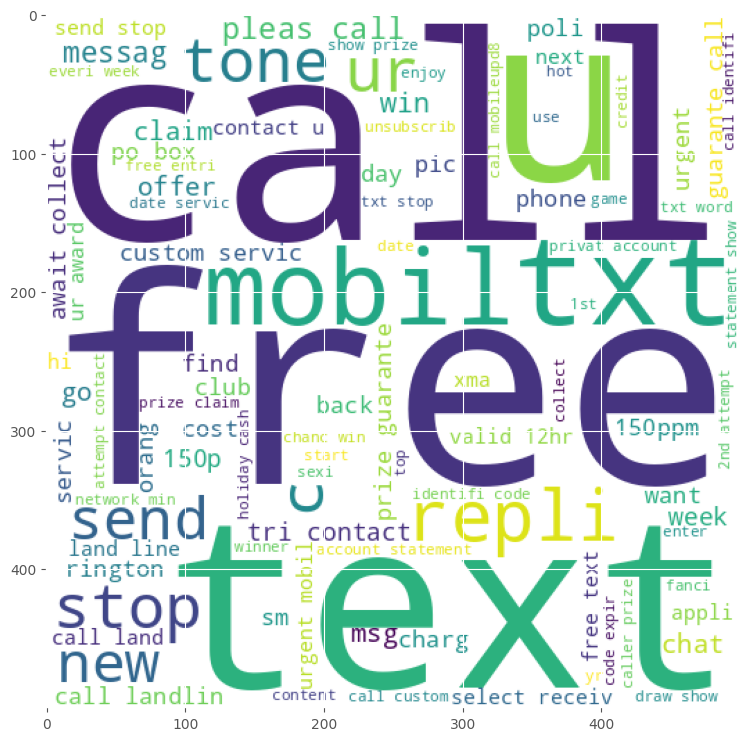

In [49]:
plt.figure(figsize=(9,9))
spam_wc = wc.generate(df[df['target'] == 1]['transformed_text'].str.cat(sep=' '))
plt.imshow(spam_wc)
plt.show()

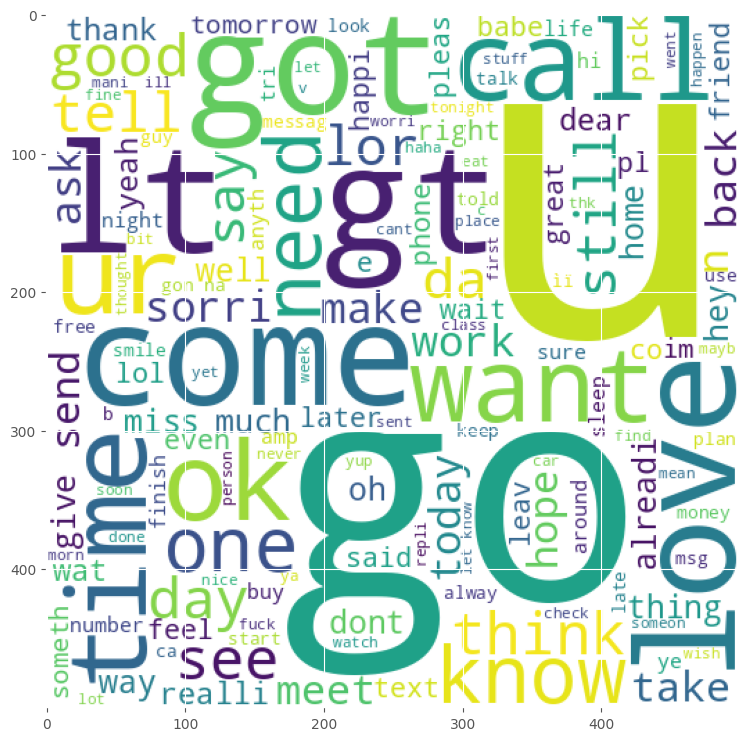

In [50]:
plt.figure(figsize=(9,9))
spam_wc = wc.generate(df[df['target'] == 0]['transformed_text'].str.cat(sep=' '))
plt.imshow(spam_wc)
plt.show()

In [51]:
df.head(2)

,target,text,num_characters,num_words,num_sentences,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni


In [54]:
spam_corpus = []
for msg in df[df['target'] == 1]['transformed_text'].tolist():
    for words in msg.split():
        spam_corpus.append(words)
len(spam_corpus)

9939

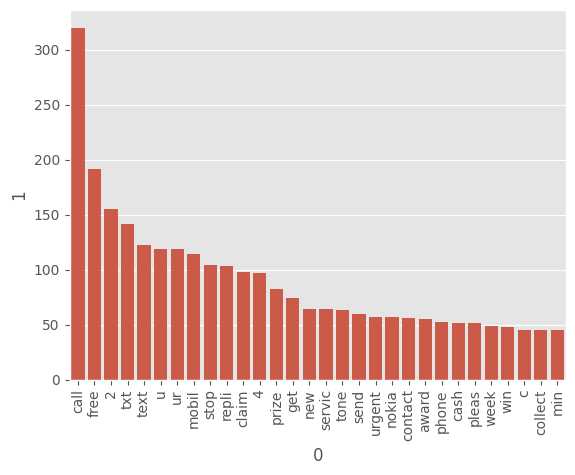

In [64]:
top_sapm = pd.DataFrame(Counter(spam_corpus).most_common(30))
sns.barplot(top_sapm, x=top_sapm[0], y=top_sapm[1])
plt.xticks(rotation=90)
plt.show()

In [65]:
ham_corpus = []
for msg in df[df['target'] == 0]['transformed_text'].tolist():
    for words in msg.split():
        ham_corpus.append(words)
len(ham_corpus)

35404

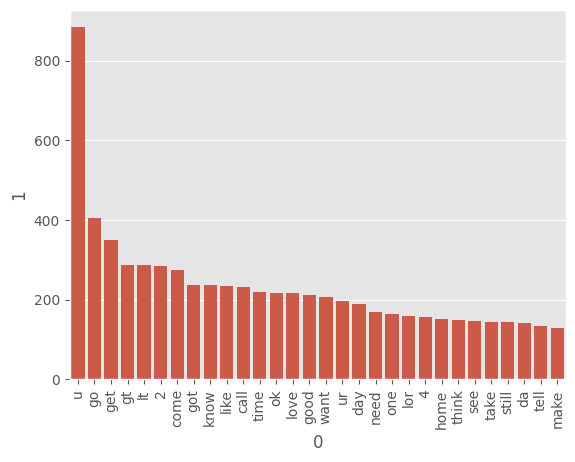

In [66]:
top_ham = pd.DataFrame(Counter(ham_corpus).most_common(30))
sns.barplot(top_ham, x=top_ham[0], y=top_ham[1])
plt.xticks(rotation=90)
plt.show()

# 4. Model Building

In [83]:
cv = CountVectorizer()
tfidf = TfidfVectorizer()

In [84]:
X = tfidf.fit_transform(df['transformed_text']).toarray()

In [85]:
y = df['target'].values

In [86]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2, random_state=True)

In [87]:
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

In [88]:
gnb.fit(X_train, y_train)
y_pred1 = gnb.predict(X_test)

print(accuracy_score(y_test, y_pred1))
print(confusion_matrix(y_test, y_pred1))
print(precision_score(y_test, y_pred1))

0.8607350096711799
[[778 121]
 [ 23 112]]
0.48068669527896996


In [89]:
mnb.fit(X_train, y_train)
y_pred2 = mnb.predict(X_test)

print(accuracy_score(y_test, y_pred2))
print(confusion_matrix(y_test, y_pred2))
print(precision_score(y_test, y_pred2))

0.9526112185686654
[[899   0]
 [ 49  86]]
1.0


In [90]:
bnb.fit(X_train, y_train)
y_pred3 = bnb.predict(X_test)

print(accuracy_score(y_test, y_pred3))
print(confusion_matrix(y_test, y_pred3))
print(precision_score(y_test, y_pred3))

0.9535783365570599
[[894   5]
 [ 43  92]]
0.9484536082474226


    We keeping the tfidf --> MNB